#<font face="Trebuchet MS" size="6">Neural Image Super-Resolution<font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><font color="#999" size="4">Latent Diffusion upscale</font><font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><a href="https://github.com/olaviinha/NeuralImageSuperResolution" target="_blank"><font color="#999" size="4">Github</font></a>

This notebook implements Superresolution Upscale from [Latent Diffusion](https://github.com/CompVis/latent-diffusion) in an attempt to improve and enhance image quality.

`input` may be a file path or a directory path. All paths should berelative to your Google Drive root. I.e. if your Google Drive has a directory called _images_ and under that directory you have a file _face.jpg_, then `input` value should be `images/face.jpg`

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image 
import PIL
def resize_image(input_path):
  image = cv2.imread(input_path)
  cv2_imshow(image)
  print(image.shape)
  new_image = cv2.resize(image, (128,128))
  #im1 = Image.open(new_image) 
  #new_image = image.resize_image((128,128,3))
  cv2_imshow(new_image)
  #im1 = im1.save("/content/drive/MyDrive/Stable_Diffusion/0.jpg")
  cv2.imwrite('/content/drive/MyDrive/Stable_Diffusion/CyberKongz_resized/2.png', new_image)
  print(new_image.shape)
  #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #cv2_imshow(image_rgb)

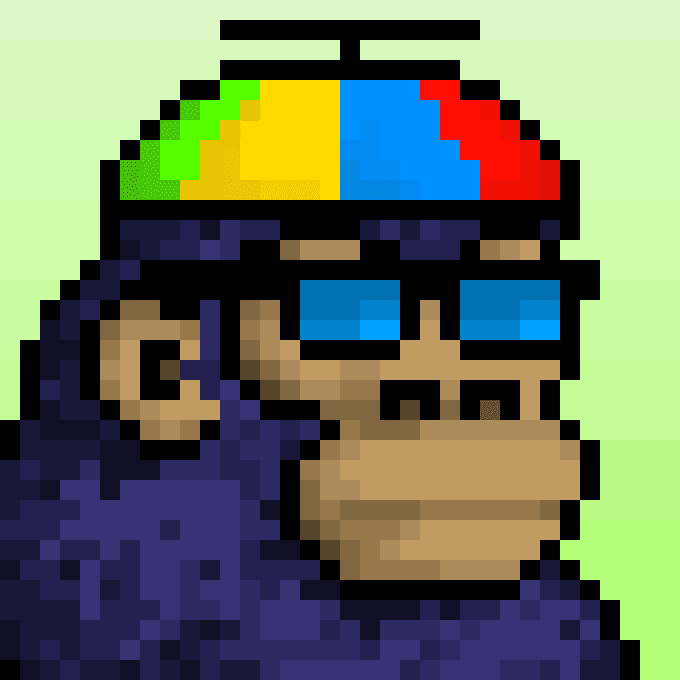

(680, 680, 3)


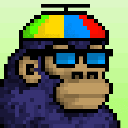

(128, 128, 3)


In [ ]:
resize_image('/content/drive/MyDrive/Stable_Diffusion/CyberKongz/2.png')

In [1]:
#@title #Setup
#@markdown This cell needs to be run only once. It will mount your Google Drive and setup prerequisites.<br>
#@markdown <small>Mounting Drive will enable this notebook to save outputs directly to your Drive. Otherwise you will need to copy/download them manually from this notebook.</small>

force_setup = False
pip_packages = 'ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops'
main_repository = 'https://github.com/CompVis/latent-diffusion.git'
mount_drive = False #@param {type:"boolean"}

# Download the repo from Github
import os
from google.colab import output
import warnings
warnings.filterwarnings('ignore')
%cd /content/

# inhagcutils
if not os.path.isfile('/content/inhagcutils.ipynb') and force_setup == False:
  !pip -q install import-ipynb {pip_packages}
  !curl -s -O https://raw.githubusercontent.com/olaviinha/inhagcutils/master/inhagcutils.ipynb
import import_ipynb
from inhagcutils import *

# Mount Drive
if mount_drive is True:
  if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
    drive_root = '/content/drive/My Drive'
  if not os.path.isdir('/content/mydrive'):
    os.symlink('/content/drive/My Drive', '/content/mydrive')
    drive_root = '/content/mydrive/'
  drive_root_set = True
else:
  create_dirs(['/content/faux_drive'])
  drive_root = '/content/faux_drive/'

if main_repository is not '':
  !git clone {main_repository}

import time, sys
from datetime import timedelta
#-- start --


!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers

sys.path.append(".")
sys.path.append('./taming-transformers')
#from taming.models import vqgan # checking correct import from taming

%cd latent-diffusion
import ipywidgets as widgets
from IPython.display import display

mode = widgets.Select(options=['superresolution'], value='superresolution', description='Task:')
#display(mode)

from notebook_helpers import get_model
model = get_model(mode.value)

from notebook_helpers import run
import torch
import numpy as np
from PIL import Image

#-- end --
output.clear()
# !nvidia-smi
op(c.ok, 'Setup finished.')

Setup finished.


In [72]:
#@title # Do stuff
input = "/content/0_1.jpg" #@param {type:"string"}
output_dir = "/content" #@param {type:"string"}
steps = 500 #@param {type:"integer"}

uniq_id = gen_id()

if os.path.isfile(input):
  inputs = [input]
  dir_in = path_dir(input)
elif os.path.isdir(input):
  dir_in = fix_path(input)
  # What to do if input is directory path
  inputs = list_images(dir_in)
elif os.path.isdir(input) and '*' in input:
  dir_in = path_dir(input)
  inputs = glob(input)
else:
  op(c.fail, 'FAIL!', 'Input should be a path to an image file or a directory of image files.')
  sys.exit('Input not understood.')

# Output
if output_dir == '':
  dir_out = dir_in
else:
  if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
  dir_out = fix_path(output_dir)
  
timer_start = time.time()

# -- DO THINGS --
for input in inputs:
  print('in:', input )
  img_out = dir_out+uniq_id+'_'+str(steps)+'steps_'+path_leaf(input)
  

  logs = run(model["model"], input, mode.value, steps)

  sample = logs["sample"]
  sample = sample.detach().cpu()
  sample = torch.clamp(sample, -1., 1.)
  sample = (sample + 1.) / 2. * 255
  sample = sample.numpy().astype(np.uint8)
  sample = np.transpose(sample, (0, 2, 3, 1))
  a = Image.fromarray(sample[0])
  a.save(img_out)
  display(a)

  if os.path.isfile(img_out):
    op(c.ok, 'Upscaled image saved as', img_out.replace(drive_root, ''))
  else:
    op(c.fail, 'Error occurred: ', input.replace(drive_root, ''))
  
# -- END THINGS --

timer_end = time.time()

print('\nElapsed', timedelta(seconds=timer_end-timer_start))
op(c.ok, 'FIN.')


Output hidden; open in https://colab.research.google.com to view.

In [16]:
!pip install pytorch-lightning==1.6.5
!pip install lightning-utilities==0.4.0
!pip install taming-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.1
    Uninstalling pytorch-lightning-2.0.1:
      Successfully uninstalled pytorch-lightning-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.1 which is incompatible.
googleapis-common-protos 1.59.0 requires proto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import cv2
import numpy as np

def combine_images(image1, image2, image3, image4):
    # Read in the four input images
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)
    img3 = cv2.imread(image3)
    img4 = cv2.imread(image4)

    # Resize the images to 64x64 pixels
    img1_resized = cv2.resize(img1, (64, 64))
    img2_resized = cv2.resize(img2, (64, 64))
    img3_resized = cv2.resize(img3, (64, 64))
    img4_resized = cv2.resize(img4, (64, 64))

    # Combine the resized images into a single 128x128 pixel image
    top_row = np.hstack((img1_resized, img2_resized))
    bottom_row = np.hstack((img3_resized, img4_resized))
    combined_img = np.vstack((top_row, bottom_row))

    cv2.imwrite('/content/final.jpg', combined_img)

    # Return the combined image
    return combined_img

In [65]:
import cv2

import cv2

def blur_and_resize_image(input_image, blur_intensity, blur_kernel_size, output_size, resize=True):
    # Read input image
    img = cv2.imread(input_image)

    # Resize image to desired output size if the resize flag is True
    if resize:
        img = cv2.resize(img, (output_size, output_size))

    # Apply Gaussian blur to image with specified intensity and kernel size
    blurred_img = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), blur_intensity)
    blurred_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite('/content/blurred_tirros.jpg', blurred_img)

    # Return blurred and (optionally) resized image
    return blurred_img



In [8]:
cc = combine_images('/content/1.png','/content/2.png','/content/3.png','/content/4.png')

In [70]:
bb = blur_and_resize_image('/content/tirros.jpg',1,15,128,False)

In [60]:
!cd ..
!cd /content

In [18]:
from PIL import Image

def split_image(image_path):
    # Open the image
    with Image.open(image_path) as img:
        # Determine the size of each split image
        width, height = img.size
        split_width = width // 2
        split_height = height // 2
        
        # Crop and save the four split images
        for i in range(2):
            for j in range(2):
                left = i * split_width
                top = j * split_height
                right = (i + 1) * split_width
                bottom = (j + 1) * split_height
                box = (left, top, right, bottom)
                split_img = img.crop(box)
                split_img.save(f"/content/{i}_{j}.jpg")

In [71]:
split_image('/content/blurred_tirros.jpg')